# Reconocedor de lengua de signos

Vamos a desarrollar una red que reconozca lengua de signos. Para ello, vamos a utilizar un dataset contenido en nuestra cuenta de Google Drive. Antes, debemos montar nuestro sistema de archivos de Google Drive para hacerlo accesible desde este *notebook*. Google nos solicitará permiso, tenemos que copiar y pegar el código que nos suministra.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Ahora ya es accesible

¿Estoy realmente utilizando una GPU? Compruébalo en **Editar / Configuración del cuaderno** o **Entorno de ejecución / Cambiar tipo de entorno de ejecución**

In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

Veamos una imagen de ejemplo.

 Bolas	       Bolas_test	 'Carátulas por géneros populares'
 Bolas_extra   Bolas_test_extra  'Carátulas por géneros populares - copia'


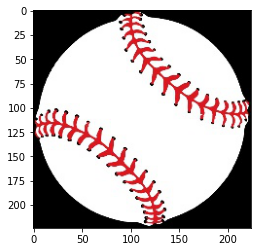

In [ ]:
!ls "/content/drive/MyDrive/Datos"

from matplotlib.pyplot import imshow
import numpy as np
from PIL import Image

%matplotlib inline
pil_im = Image.open('/content/drive/MyDrive/Datos/Bolas/baseball/001.jpg', 'r')
imshow(np.asarray(pil_im))
path = '/content/drive/MyDrive/Datos'


## Primer modelo

In [ ]:
# DATA SOURCE --------------------------------------------------

image_size = (150, 150)
batch_size = 32

from keras.preprocessing.image import ImageDataGenerator
from skimage import io
import os

train_data_dir = path + '/Bolas'  
validation_data_dir = path + '/Bolas_test'

train_datagen = ImageDataGenerator(
    zoom_range=0.2,
    rotation_range = 5,
    horizontal_flip=True,
    brightness_range = (0.5, 1.5))

test_datagen = ImageDataGenerator()

train_ds = train_datagen.flow_from_directory(  
    train_data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical')

val_ds = test_datagen.flow_from_directory(  
    validation_data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical')

Found 608 images belonging to 5 classes.
Found 25 images belonging to 5 classes.


In [ ]:
# MODEL --------------------------------------------------

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Dense, Rescaling, Flatten
from tensorflow.keras.callbacks import EarlyStopping

model = keras.Sequential()
model.add(Rescaling(scale=(1./127.5),
                    offset=-1, 
                    input_shape=(150, 150, 3)))
model.add(Conv2D(32, kernel_size=(4, 4), activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Conv2D(64, (4, 4), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, (4, 4), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))

model.compile(loss=tf.keras.losses.categorical_crossentropy,
              optimizer=tf.keras.optimizers.Adam(1e-3),
              metrics=['accuracy'])

In [ ]:
# TRAINING --------------------------------------------------

epochs = 200

es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=10, restore_best_weights=True)

h = model.fit(
        train_ds,
        epochs=epochs, 
        validation_data=val_ds,
        callbacks = [es]
)

Epoch 1/200
19/19 [==============================] - 7s 341ms/step - loss: 0.6327 - accuracy: 0.7747 - val_loss: 0.2410 - val_accuracy: 0.9600
Epoch 2/200
19/19 [==============================] - 6s 335ms/step - loss: 0.4853 - accuracy: 0.8438 - val_loss: 0.1661 - val_accuracy: 0.9600
Epoch 3/200
19/19 [==============================] - 6s 334ms/step - loss: 0.5042 - accuracy: 0.8355 - val_loss: 0.2001 - val_accuracy: 0.9600
Epoch 4/200
19/19 [==============================] - 6s 328ms/step - loss: 0.4466 - accuracy: 0.8421 - val_loss: 0.2319 - val_accuracy: 0.9600
Epoch 5/200
19/19 [==============================] - 6s 323ms/step - loss: 0.4152 - accuracy: 0.8536 - val_loss: 0.2020 - val_accuracy: 0.9200
Epoch 6/200
19/19 [==============================] - 6s 322ms/step - loss: 0.4476 - accuracy: 0.8487 - val_loss: 0.1757 - val_accuracy: 0.9600
Epoch 7/200
19/19 [==============================] - 6s 323ms/step - loss: 0.3999 - accuracy: 0.8668 - val_loss: 0.1878 - val_accuracy: 0.9600

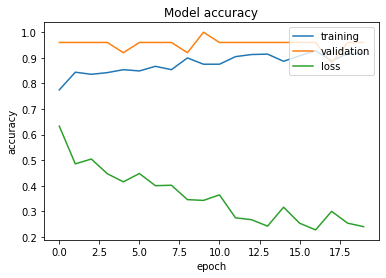

In [ ]:
import matplotlib.pyplot as plt

plt.plot(h.history['accuracy'])
plt.plot(h.history['val_accuracy'])
plt.plot(h.history['loss'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation','loss'], loc='upper right')
plt.show()

## Evaluación de los resultados

Found 608 files belonging to 5 classes.
Using 487 files for training.
Found 608 files belonging to 5 classes.
Using 121 files for validation.
              precision    recall  f1-score   support

           0     0.8333    0.9524    0.8889        21
           1     0.7368    1.0000    0.8485        14
           2     0.9444    0.8500    0.8947        20
           3     1.0000    0.7838    0.8788        37
           4     0.8710    0.9310    0.9000        29

    accuracy                         0.8843       121
   macro avg     0.8771    0.9034    0.8822       121
weighted avg     0.9005    0.8843    0.8848       121



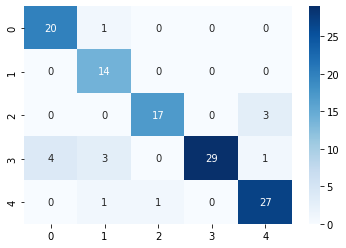

In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/Datos/Bolas",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    label_mode='categorical'
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/Datos/Bolas",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    label_mode='categorical'
)

train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

results = np.concatenate([(y, model.predict(x=x)) for x, y in val_ds], axis=1)

predictions = np.argmax(results[0], axis=1)
labels = np.argmax(results[1], axis=1)

cf_matrix = confusion_matrix(labels, predictions)

sns.heatmap(cf_matrix, annot=True, fmt="d", cmap="Blues")

print(classification_report(labels, predictions, digits = 4))

In [ ]:
img = keras.preprocessing.image.load_img(
    '/content/drive/MyDrive/Datos/Bolas_test/baseball/4.jpg', target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
print(predictions)
print(np.argmax(predictions[0]))

[[8.68691325e-01 1.28841028e-01 2.88141200e-06 2.35828571e-03
  1.06423104e-04]]
0


In [ ]:
#GUARDAR RED

model_json = model.to_json()
with open("/content/drive/MyDrive/Redes/model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("/content/drive/MyDrive/Redes/model.h5")

In [ ]:
#CARGAR RED

# load json and create model
json_file = open('/content/drive/MyDrive/Redes/model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
# load weights into new model
model.load_weights("/content/drive/MyDrive/Redes/model.h5")